# Packages

In [1]:
##uncomment to install libraries
!pip install gputil
!pip install psutil
!pip install humanize

  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7395 sha256=8d63067314ae2410244f973ae6faa5f63ab92f1757cf1580f5780c3bd83f7da5
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built gputil


In [2]:
# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# torchvision
import torchvision
import torchvision.transforms.v2 as transforms

# plots
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# metrics
from sklearn.metrics import confusion_matrix

# utils
import time
import numpy as np
import os
import copy

##gpu
import psutil
import humanize
import GPUtil as GPU

In [3]:
##to find out about the information for computational requirements for the gpu

GPUs = GPU.getGPUs()

if GPUs:
    gpu = GPUs[0]  # only picked one gpu, we only had one available
    print(f"GPU Name: {gpu.name}")
    print(f"GPU Driver: {gpu.driver}")
    print(f"GPU Memory Total: {humanize.naturalsize(gpu.memoryTotal)}")
    print(f"GPU Memory Free: {humanize.naturalsize(gpu.memoryFree)}")
    print(f"GPU Memory Used: {humanize.naturalsize(gpu.memoryUsed)}")
else:
    print("No GPU available.")

# CPU information
print(f"\nCPU Cores: {psutil.cpu_count(logical=False)}")
print(f"CPU Threads: {psutil.cpu_count(logical=True)}")

GPU Name: Tesla T4
GPU Driver: 525.105.17
GPU Memory Total: 15.4 kB
GPU Memory Free: 15.1 kB
GPU Memory Used: 0 Bytes

CPU Cores: 1
CPU Threads: 2


In [4]:
!nvidia-smi

Mon Nov 20 17:26:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Data

In [5]:
if os.path.exists("./data/cifar-10-python.tar.gz") == False:
    download = True
else:
    download = False

dataset_train = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=download, transform=transforms.ToTensor()
)
dataset_test = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=download, transform=transforms.ToTensor()
)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
100%|██████████| 170498071/170498071 [00:01<00:00, 89872562.26it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
cifar10_mean = np.mean(dataset_train.data / 255.0, axis=(0, 1, 2))
cifar10_std = np.std(dataset_train.data / 255.0, axis=(0, 1, 2))
transform = transforms.Compose(
    [
        # first cast the data to a pytorch tensor
        transforms.ToTensor(),
        # then define mean and std for the normalization (RMK: for each channel)
        # output[channel] = (input[channel] - mean[channel]) / std[channel]
        transforms.Normalize(mean=cifar10_mean, std=cifar10_std),
    ]
)

if os.path.exists("./data/cifar-10-python.tar.gz") == False:
    download = True
else:
    download = False

dataset_train = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=download, transform=transform
)
dataset_test = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=download, transform=transform
)

classes = dataset_train.classes

## Training dataset split

In [7]:
torch.manual_seed(42)
# This just splits the indices into two subsets basically
train_subset, val_subset = torch.utils.data.random_split(dataset_train, [0.8, 0.2])

## Data loaders

In [8]:
batch_size = 128  # hyperparameter
trainloader = torch.utils.data.DataLoader(
    train_subset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True
)
valloader = torch.utils.data.DataLoader(
    val_subset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True
)
testloader = torch.utils.data.DataLoader(
    dataset_test, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True
)

# Model

In [9]:
class VGG13(nn.Module):
    def __init__(self, num_classes, batch_norm=False, dropout=False):
        super(VGG13, self).__init__()
        self.batch_norm = batch_norm

        self.conv_layers = nn.ModuleList(
            [
                nn.Conv2d(3, 64, kernel_size=3, padding=1),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.Conv2d(64, 128, kernel_size=3, padding=1),
                nn.Conv2d(128, 128, kernel_size=3, padding=1),
                nn.Conv2d(128, 256, kernel_size=3, padding=1),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                nn.Conv2d(256, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
            ]
        )

        self.pool_layers = nn.ModuleList(
            [
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
            ]
        )

        if self.batch_norm:
            self.norm_layers = nn.ModuleList(
                [
                    nn.BatchNorm2d(64),
                    nn.BatchNorm2d(64),
                    nn.BatchNorm2d(128),
                    nn.BatchNorm2d(128),
                    nn.BatchNorm2d(256),
                    nn.BatchNorm2d(256),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                ]
            )
        else:
            self.norm_layers = nn.ModuleList(
                [
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                ]
            )

        if dropout:
            self.classifier = nn.Sequential(
                # 1st block
                nn.Linear(512 * 1 * 1, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                # 2nd block
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                # output
                nn.Linear(4096, num_classes),
            )
        else:
            self.classifier = nn.Sequential(
                # 1st block
                nn.Linear(512 * 1 * 1, 4096),
                nn.ReLU(inplace=True),
                # 2nd block
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                # output
                nn.Linear(4096, num_classes),
            )

    def forward(self, x):
        for conv, norm, pool in zip(
            self.conv_layers, self.norm_layers, self.pool_layers
        ):
            x = conv(x)
            x = norm(x)
            F.relu(x, inplace=True)
            x = pool(x)

        # flatten
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Training

### Utils

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda:0


In [11]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta  # minimum improvement to reset patience
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model)
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model.load_state_dict(model.state_dict())
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.status = f"Stopped on {self.counter}"
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model.state_dict())
                return True
        self.status = f"{self.counter}/{self.patience}"
        return False

In [12]:
#to check memory usage and gpu status
!nvidia-smi

Mon Nov 20 17:26:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Train loop

In [13]:
def train_model(
    model,
    n_epochs,
    trainloader,
    valloader,
    optimizer,
    loss_fn,
    early_stopping=False,
    verbose=True,
):
    n_records = 5
    check_train = len(trainloader) // n_records
    check_val = len(valloader) // n_records

    training_loss = []
    training_accuracy = []
    validation_loss = []
    validation_accuracy = []

    if early_stopping:
        early_stop = EarlyStopping(patience=5, restore_best_weights=False)

    for epoch in range(n_epochs):
        # train the model
        correct = 0
        total = 0
        running_loss = 0
        tot_samples = 0
        model.train()
        for i, (data, target) in enumerate(trainloader):
            # move tensors to GPU if CUDA is available
            data = data.to(device)
            target = target.to(device)
            # forward pass
            output = model(data)
            # calculate the batch loss
            loss = loss_fn(output, target)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            tot_samples += 1
            if verbose and (i + 1) % check_train == 0:
                _, pred = torch.max(output, dim=1)
                correct += (pred == target).sum().item()
                total += batch_size
                accuracy = correct / total
                training_loss.append(running_loss / tot_samples)
                training_accuracy.append(accuracy)
                print(
                    f"Epoch {epoch + 1}"
                    + f"\tTraining loss: {loss.item():.6f}"
                    + f"\tRunning loss: {running_loss / tot_samples:.6f}"
                    + f"\tTraining partial incremental accuracy: {accuracy * 100:.2f}"
                )
                running_loss = 0
                tot_samples = 0
        # validate the model
        with torch.no_grad():
            model.eval()
            correct = 0
            total = 0
            running_loss = 0
            tot_samples = 0
            for i, (data, target) in enumerate(valloader):
                # move tensors to GPU if CUDA is available
                data = data.to(device)
                target = target.to(device)
                # forward pass
                output = model(data)
                _, pred = torch.max(output, dim=1)
                correct += (pred == target).sum().item()
                total += batch_size
                loss = loss_fn(output, target).item()
                running_loss += loss
                tot_samples += 1
                if verbose and (i + 1) % check_val == 0:
                    # calculate the batch loss
                    accuracy = correct / total
                    validation_loss.append(running_loss / tot_samples)
                    validation_accuracy.append(accuracy)
                    print(
                        f"Epoch {epoch + 1}"
                        + f"\tValidation loss: {loss:.6f}"
                        + f"\tRunning loss: {running_loss / tot_samples:.6f}"
                        + f"\tAccuracy: {accuracy * 100:.2f}"
                    )
                    running_loss = 0
                    tot_samples = 0

        if early_stopping and early_stop(model, validation_loss[-1]):
            print(f"Stopped trained at epoch {epoch + 1}")
            if early_stop.restore_best_weights:
                print(
                    f"Restored model trained at epoch {epoch + 1 - early_stop.counter}"
                )
            break

    return (
        training_loss,
        training_accuracy,
        validation_loss,
        validation_accuracy,
    )

In [14]:
torch.manual_seed(42)
vgg = VGG13(num_classes=10)
# print(vgg)
# print(check_train)
# print(check_val)

optimizer = optim.Adam(
    vgg.parameters(),
    lr=0.0005,
)

loss_fn = nn.CrossEntropyLoss()

n_epochs = 30

vgg = vgg.to(device)

start = time.time()
(
    training_loss,
    training_accuracy,
    validation_loss,
    validation_accuracy,
) = train_model(
    vgg,
    n_epochs,
    trainloader,
    valloader,
    optimizer,
    loss_fn,
    early_stopping=True,
    verbose=True,
)
end = time.time()
print(f"Training took {end - start:.2f} seconds")

Epoch 1	Training loss: 2.116258	Running loss: 2.251010	Training partial incremental accuracy: 14.06
Epoch 1	Training loss: 1.898516	Running loss: 2.030590	Training partial incremental accuracy: 21.09
Epoch 1	Training loss: 2.055118	Running loss: 1.926008	Training partial incremental accuracy: 19.53
Epoch 1	Training loss: 1.754329	Running loss: 1.842602	Training partial incremental accuracy: 23.44
Epoch 1	Training loss: 1.666100	Running loss: 1.777597	Training partial incremental accuracy: 24.84
Epoch 1	Validation loss: 1.615327	Running loss: 1.700568	Accuracy: 30.83
Epoch 1	Validation loss: 1.738417	Running loss: 1.716775	Accuracy: 30.18
Epoch 1	Validation loss: 1.614544	Running loss: 1.741341	Accuracy: 30.50
Epoch 1	Validation loss: 1.673639	Running loss: 1.720438	Accuracy: 30.43
Epoch 1	Validation loss: 1.716457	Running loss: 1.719095	Accuracy: 30.30
Epoch 2	Training loss: 1.685848	Running loss: 1.667892	Training partial incremental accuracy: 33.59
Epoch 2	Training loss: 1.412957	Run

### Test

In [15]:
# test accuracy
vgg.eval()
correct = 0
total = 0

start = time.time()
with torch.no_grad():
    for data, target in testloader:
        # move tensors to GPU if CUDA is available
        data = data.to(device)
        target = target.to(device)
        # forward pass
        output = vgg(data)
        _, pred = torch.max(output, dim=1)
        total += target.size(0)
        correct += (pred == target).sum().item()
end = time.time()

print(f"Test accuracy: {correct / total * 100:.2f}%")
print(f"Test took {end - start:.2f} seconds")

Test accuracy: 77.36%
Test took 3.17 seconds


### Inference time test

In [61]:
vgg.eval()
test_iter = iter(testloader)
np.random.seed(666)
for i in range(np.random.randint(0, len(testloader))):
    img_batch, target_batch = next(test_iter)
img_idx = np.random.randint(batch_size)
img = img_batch[img_idx]
target = target_batch[img_idx]
img = img.unsqueeze(0).to(device)

with torch.no_grad():
    start = time.time()
    output = vgg(img)
    end = time.time()
    print(f"Inference time {end - start:.8f} seconds")
    print(f"Output: {output}")
    _, pred = torch.max(output, dim=1)
    print(f"Prediction: {classes[pred]}")
    print(f"Target: {classes[target]}")

Inference time 0.00606108 seconds
Output: tensor([[-1.2517, -4.7615, -1.6615,  0.6327, -6.3724, -1.4537, -2.6551, -2.6213,
          4.6736, -3.5014]], device='cuda:0')
Prediction: ship
Target: ship


In [17]:
#to check memory usage and gpu status
!nvidia-smi


Mon Nov 20 17:30:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    31W /  70W |   2167MiB / 15360MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Learning curves

Text(0, 0.5, 'Loss')

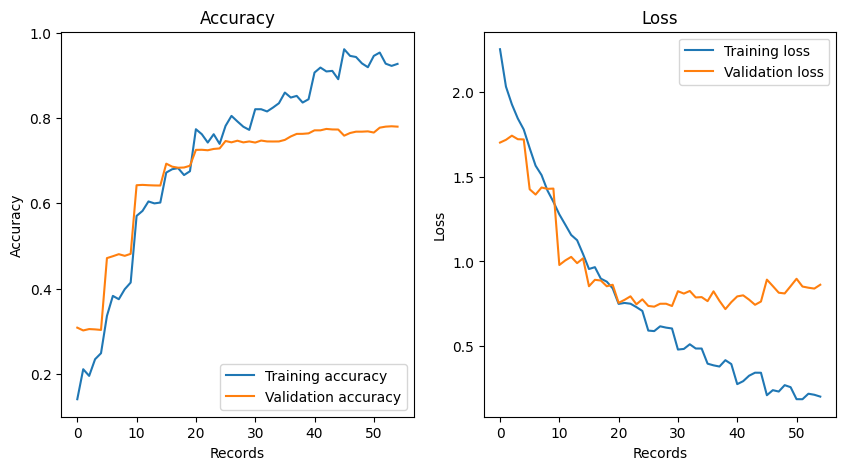

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(training_accuracy, label="Training accuracy")
axs[0].plot(validation_accuracy, label="Validation accuracy")
axs[0].legend(loc="lower right")
axs[0].set_title("Accuracy")
axs[0].set_xlabel("Records")
axs[0].set_ylabel("Accuracy")

axs[1].plot(training_loss, label="Training loss")
axs[1].plot(validation_loss, label="Validation loss")
axs[1].legend(loc="upper right")
axs[1].set_title("Loss")
axs[1].set_xlabel("Records")
axs[1].set_ylabel("Loss")

### Confusion matrix

In [19]:
def compute_confusion_matrix(model, testloader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data, target in testloader:
            # move tensors to GPU if CUDA is available
            data = data.to(device)
            target = target.to(device)
            # forward pass
            output = model(data)
            _, pred = torch.max(output, dim=1)
            y_true.append(target.cpu().numpy())
            y_pred.append(pred.cpu().numpy())

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    return confusion_matrix(y_true, y_pred, normalize="true") * 100

In [20]:
conf_mat = compute_confusion_matrix(vgg, testloader)
print(conf_mat)

[[86.   0.8  4.4  1.1  2.   0.   0.4  0.9  2.8  1.6]
 [ 1.9 88.7  0.4  0.5  0.2  0.1  1.   0.   2.3  4.9]
 [ 7.4  0.  67.3  6.1  7.   4.6  5.6  1.6  0.3  0.1]
 [ 1.5  0.7  7.6 63.6  5.7 11.6  6.3  1.6  1.1  0.3]
 [ 2.   0.   5.6  7.  75.9  2.4  4.5  2.3  0.2  0.1]
 [ 1.   0.3  4.6 22.3  4.2 62.7  2.5  2.   0.3  0.1]
 [ 0.6  0.2  5.   6.9  2.2  0.2 84.4  0.2  0.2  0.1]
 [ 0.9  0.1  3.4  4.3 10.4  6.8  0.6 72.   0.3  1.2]
 [ 6.4  0.5  1.2  1.8  0.3  0.1  0.5  0.  88.   1.2]
 [ 3.4  6.1  0.3  2.1  0.1  0.2  0.2  0.6  2.  85. ]]


<Axes: >

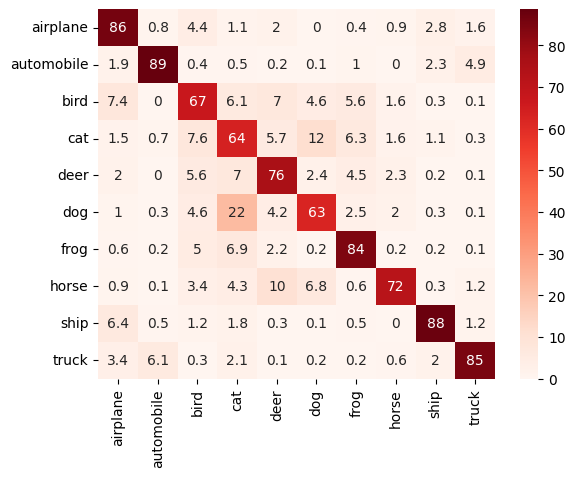

In [21]:
sns.heatmap(
    conf_mat, annot=True, cmap=cm.Reds, xticklabels=classes, yticklabels=classes
)

# Early exit

## B-NET

In [22]:
#to check memory usage and gpu status
!nvidia-smi

Mon Nov 20 17:30:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    30W /  70W |   2167MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Early exit decision criterion

In [23]:
def entropy(x):
    p = F.softmax(x.detach(), dim=1)
    H = -torch.mean(p * torch.log(p + 1e-8), dim=1)
    return H

### Model

In [24]:
def create_early_exit(in_shape, in_channels, num_classes):
    return nn.Sequential(
        # Convolution
        nn.Conv2d(in_channels, 128, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        # Global average pooling
        # nn.AdaptiveAvgPool2d(1),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        # classifier
        nn.Linear(128 * in_shape // 2 * in_shape // 2, num_classes),
    )

In [25]:
class BVGG13(nn.Module):
    def __init__(self, num_classes, batch_norm=False, dropout=False):
        super(BVGG13, self).__init__()
        self.batch_norm = batch_norm
        self.dropout = dropout
        self.set_exit_threshold(0.0)

        self.conv_layers = nn.ModuleList(
            [
                nn.Conv2d(3, 64, kernel_size=3, padding=1),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.Conv2d(64, 128, kernel_size=3, padding=1),
                nn.Conv2d(128, 128, kernel_size=3, padding=1),
                nn.Conv2d(128, 256, kernel_size=3, padding=1),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                nn.Conv2d(256, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
            ]
        )

        self.pool_layers = nn.ModuleList(
            [
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
            ]
        )

        if self.batch_norm:
            self.norm_layers = nn.ModuleList(
                [
                    nn.BatchNorm2d(64),
                    nn.BatchNorm2d(64),
                    nn.BatchNorm2d(128),
                    nn.BatchNorm2d(128),
                    nn.BatchNorm2d(256),
                    nn.BatchNorm2d(256),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                ]
            )
        else:
            self.norm_layers = nn.ModuleList(
                [
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                ]
            )

        if self.dropout:
            self.classifier = nn.Sequential(
                # 1st block
                nn.Linear(512 * 1 * 1, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                # 2nd block
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                # output
                nn.Linear(4096, num_classes),
            )
        else:
            self.classifier = nn.Sequential(
                # 1st block
                nn.Linear(512 * 1 * 1, 4096),
                nn.ReLU(inplace=True),
                # 2nd block
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                # output
                nn.Linear(4096, num_classes),
            )

        self.early_exits = nn.ModuleList(
            [
                create_early_exit(32, 64, num_classes),
                create_early_exit(16, 64, num_classes),
                create_early_exit(16, 128, num_classes),
                create_early_exit(8, 128, num_classes),
                create_early_exit(8, 256, num_classes),
                create_early_exit(4, 256, num_classes),
                create_early_exit(4, 512, num_classes),
                create_early_exit(2, 512, num_classes),
                create_early_exit(2, 512, num_classes),
            ]
        )

    def forward(self, x, inference=False):
        out = []
        e = 0
        for conv, norm, pool in zip(
            self.conv_layers, self.norm_layers, self.pool_layers
        ):
            x = conv(x)
            x = norm(x)
            F.relu(x, inplace=True)
            x = pool(x)
            if e < len(self.early_exits):
                x_ee = self.early_exits[e](x)
                out.append(x_ee)
                e += 1
            if inference:
                # x is a single image, otherwise we would have to loop over the batch dimension
                H = entropy(x_ee)
                if torch.less(H, self.exit_threshold):
                    return x_ee, H, e

        # flatten
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        out.append(x)
        if inference:
            return x, H, e
        return out

    def set_exit_threshold(self, exit_threshold):
        self.exit_threshold = torch.tensor(exit_threshold)

### Custom loss function

In [26]:
class JointCrossEntropy(nn.Module):
    def __init__(self):
        super(JointCrossEntropy, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, outputs, targets):
        loss = 0
        for output in outputs:
            loss += self.cross_entropy(output, targets)
        return loss

In [27]:
#to check memory usage and gpu status
!nvidia-smi

Mon Nov 20 17:30:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    30W /  70W |   2167MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Training loop

In [28]:
def train_model_ee(
    model,
    n_epochs,
    trainloader,
    valloader,
    optimizer,
    loss_fn,
    early_stopping=False,
    verbose=True,
):
    n_records = 5
    check_train = len(trainloader) // n_records
    check_val = len(valloader) // n_records

    training_loss = []
    training_accuracy = []
    validation_loss = []
    validation_accuracy = []

    if early_stopping:
        early_stop = EarlyStopping(patience=5, restore_best_weights=False)

    for epoch in range(n_epochs):
        # train the model
        correct = np.zeros(len(model.early_exits) + 1)
        total = 0
        running_loss = 0
        tot_samples = 0
        model.train()
        for i, (data, target) in enumerate(trainloader):
            # move tensors to GPU if CUDA is available
            data = data.to(device)
            target = target.to(device)
            # forward pass
            output = model(data)
            # calculate the batch loss
            loss = loss_fn(output, target)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            tot_samples += 1
            if verbose and (i + 1) % check_train == 0:
                print_str = f"Epoch {epoch + 1}\tTraining loss: {running_loss / tot_samples:.4f}"
                training_loss.append(running_loss / tot_samples)
                total += batch_size
                for i, out in enumerate(output):
                    _, pred = torch.max(out, dim=1)
                    correct[i] += (pred == target).sum().item()
                accuracy = correct / total
                training_accuracy.append(accuracy)
                accuracy = np.round(accuracy * 100, 2)
                print_str += f"\tAccuracy: {accuracy.__str__()}"
                running_loss = 0
                tot_samples = 0
                print(print_str)
        # validate the model
        with torch.no_grad():
            model.eval()
            correct = np.zeros(len(model.early_exits) + 1)
            total = 0
            running_loss = 0
            tot_samples = 0
            for i, (data, target) in enumerate(valloader):
                # move tensors to GPU if CUDA is available
                data = data.to(device)
                target = target.to(device)
                # forward pass
                output = model(data)
                loss = loss_fn(output, target).item()
                running_loss += loss
                tot_samples += 1
                if verbose and (i + 1) % check_val == 0:
                    print_str = f"Epoch {epoch + 1}\tValidation loss: {running_loss / tot_samples:.4f}"
                    validation_loss.append(running_loss / tot_samples)
                    total += batch_size
                    for i, out in enumerate(output):
                        _, pred = torch.max(out, dim=1)
                        correct[i] += (pred == target).sum().item()
                    accuracy = correct / total
                    validation_accuracy.append(accuracy)
                    accuracy = np.round(accuracy * 100, 2)
                    print_str += f"\tAccuracy: {accuracy.__str__()}"
                    running_loss = 0
                    tot_samples = 0
                    print(print_str)

        if early_stopping and early_stop(model, validation_loss[-1]):
            print(f"Stopped trained at epoch {epoch + 1}")
            if early_stop.restore_best_weights:
                print(
                    f"Restored model trained at epoch {epoch + 1 - early_stop.counter}"
                )
            break

    return (
        training_loss,
        training_accuracy,
        validation_loss,
        validation_accuracy,
    )

In [29]:
torch.manual_seed(42)
bvgg = BVGG13(num_classes=10)
# print(vgg)
# print(check_train)
# print(check_val)

optimizer = optim.Adam(
    bvgg.parameters(),
    lr=0.0005,
)

loss_fn = JointCrossEntropy()

n_epochs = 30

bvgg.to(device)

start = time.time()
(
    training_loss,
    training_accuracy,
    validation_loss,
    validation_accuracy,
) = train_model_ee(
    bvgg,
    n_epochs,
    trainloader,
    valloader,
    optimizer,
    loss_fn,
    early_stopping=True,
    verbose=True,
)
end = time.time()
print(f"Training took {end - start:.2f} seconds")

Epoch 1	Training loss: 20.0336	Accuracy: [47.66 42.19 43.75 39.84 35.94 32.81 32.81 30.47 25.78 23.44]
Epoch 1	Training loss: 16.6234	Accuracy: [51.17 47.27 44.92 44.92 39.45 39.06 38.67 35.55 32.81 30.08]
Epoch 1	Training loss: 15.1149	Accuracy: [55.73 50.78 48.18 46.09 42.19 41.41 39.06 38.28 36.2  33.85]
Epoch 1	Training loss: 14.2566	Accuracy: [57.03 52.34 50.78 47.27 43.36 42.58 40.23 39.26 36.72 35.35]
Epoch 1	Training loss: 13.5653	Accuracy: [58.75 54.06 52.66 48.75 45.78 43.75 41.56 40.62 38.75 37.5 ]
Epoch 1	Validation loss: 12.4662	Accuracy: [71.88 64.06 67.97 67.19 64.06 60.16 60.16 57.03 53.91 48.44]
Epoch 1	Validation loss: 12.4730	Accuracy: [67.58 60.94 62.5  60.16 56.64 54.69 53.12 51.17 49.61 47.27]
Epoch 1	Validation loss: 12.7678	Accuracy: [66.93 61.46 63.28 59.64 57.55 54.95 53.91 50.78 48.7  47.4 ]
Epoch 1	Validation loss: 12.5811	Accuracy: [65.23 61.13 62.7  58.2  56.64 54.49 52.54 51.17 49.02 47.66]
Epoch 1	Validation loss: 12.7311	Accuracy: [64.38 61.09 62.19 56.

### Test data

In [30]:
# test accuracy
bvgg.eval()

with torch.no_grad():
    for i in range(10):
        correct = 0
        total = 0
        start = time.time()
        for data, target in testloader:
            # move tensors to GPU if CUDA is available
            data = data.to(device)
            target = target.to(device)
            # forward pass
            output = bvgg(data, inference=False)
            # Test accuracy on the final exit
            _, pred = torch.max(output[i], dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)
        end = time.time()
        print(f"Exit {i+1} test accuracy: {correct / total * 100:.2f}%")
        print(f"Test took {end - start:.2f} seconds")
avg_acc = correct / total
print(f"the average test accuracy is {100*avg_acc}")

Exit 1 test accuracy: 68.37%
Test took 3.16 seconds
Exit 2 test accuracy: 75.18%
Test took 3.13 seconds
Exit 3 test accuracy: 76.79%
Test took 3.12 seconds
Exit 4 test accuracy: 76.86%
Test took 4.86 seconds
Exit 5 test accuracy: 78.47%
Test took 3.21 seconds
Exit 6 test accuracy: 79.12%
Test took 3.13 seconds
Exit 7 test accuracy: 80.48%
Test took 3.18 seconds
Exit 8 test accuracy: 80.61%
Test took 4.40 seconds
Exit 9 test accuracy: 80.41%
Test took 3.55 seconds
Exit 10 test accuracy: 80.26%
Test took 3.09 seconds
the average test accuracy is 80.25999999999999


### Inference time

In [31]:
bvgg.eval()
test_iter = iter(testloader)
np.random.seed(666)
for i in range(np.random.randint(0, len(testloader))):
    img_batch, target_batch = next(test_iter)
img_idx = np.random.randint(batch_size)
img = img_batch[img_idx]
target = target_batch[img_idx]
img = img.unsqueeze(0).to(device)

bvgg.set_exit_threshold(0.1)
with torch.no_grad():
    start = time.time()
    output, H, e = bvgg(img, inference=True)
    end = time.time()
    print(f"Inference time {end - start:.8f} seconds")
    print(f"Exit: {e+1}")
    print(f"Entropy: {H.detach().cpu()}")
    print(f"Output: {output.detach().cpu()}")
    _, pred = torch.max(output, dim=1)
    print(f"Prediction: {classes[pred]}")
    print(f"Target: {classes[target]}")

Inference time 0.02149892 seconds
Exit: 2
Entropy: tensor([0.0002])
Output: tensor([[ -1.5585, -13.6606,  -3.3505,  -9.2991,  -3.1638,  -3.0499,  -9.2745,
          -5.9725,   7.6347,  -6.5244]])
Prediction: ship
Target: ship


In [32]:
#to check memory usage and gpu status
!nvidia-smi

Mon Nov 20 17:36:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    38W /  70W |   2841MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Learning curves.

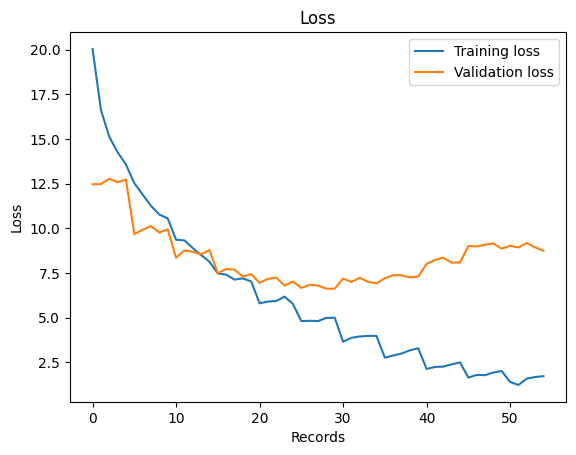

In [33]:
plt.plot(training_loss, label="Training loss")
plt.plot(validation_loss, label="Validation loss")
plt.legend(loc="upper right")
plt.title("Loss")
plt.xlabel("Records")
plt.ylabel("Loss")
plt.show()

(55, 10)


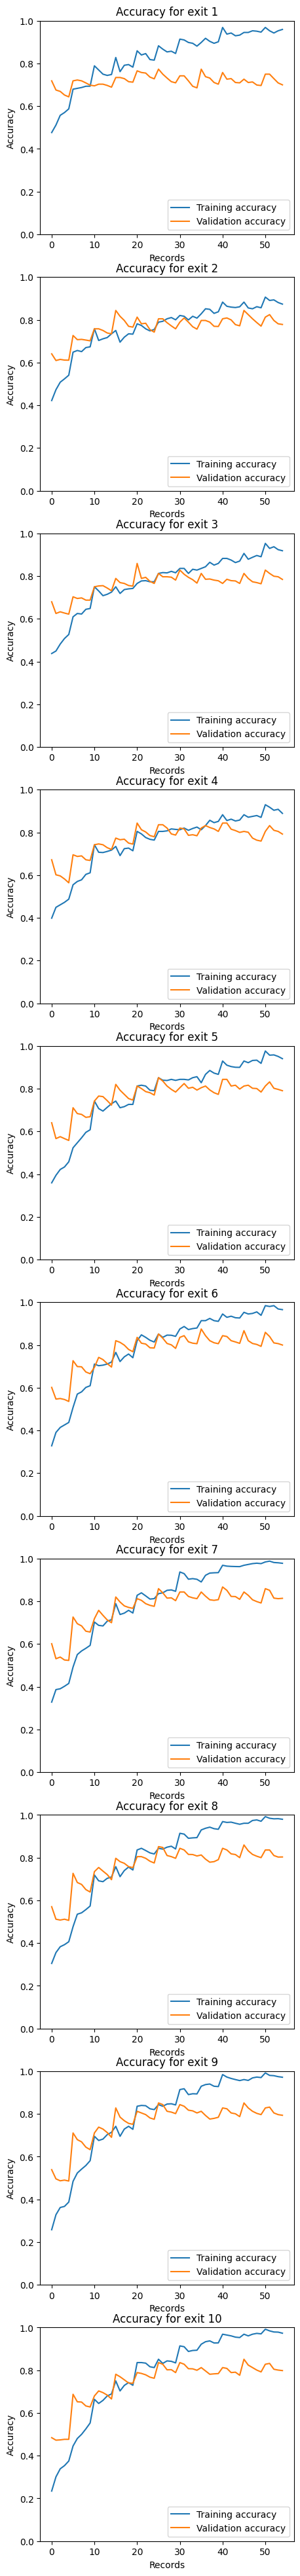

In [34]:
training_accuracy = np.array(training_accuracy)
validation_accuracy = np.array(validation_accuracy)
print(training_accuracy.shape)
fig, axs = plt.subplots(10, 1, figsize=(5, 50))
axs = axs.flatten()
for i in range(10):
    axs[i].plot(training_accuracy[:, i], label="Training accuracy")
    axs[i].plot(validation_accuracy[:, i], label="Validation accuracy")
    axs[i].legend(loc="lower right")
    axs[i].set_title(f"Accuracy for exit {i + 1}")
    axs[i].set_xlabel("Records")
    axs[i].set_ylabel("Accuracy")
    axs[i].set_ylim([0, 1])

## Proposed algorithm for training

In [35]:
#to check memory usage and gpu status
!nvidia-smi

Mon Nov 20 17:36:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    29W /  70W |   2841MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Early exit decision criterion.

Based on:
- Entropy of the logits;
- Probability of the guess.

In [36]:
def entropy(x):
    p = F.softmax(x, dim=1)
    H = -torch.mean(p * torch.log(p + 1e-8), dim=1)
    return H

In [37]:
def find_max_prob(x):
    p = F.softmax(x, dim=1)
    return torch.max(p, dim=1).values

### Model

Function to create auxiliary branches in the network, based on the input shape of the image and the number of input channels (aka the depth of the feature map).

In [38]:
def create_early_exit(in_shape, in_channels, num_classes):
    return nn.Sequential(
        # Convolution
        nn.Conv2d(in_channels, 128, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        # Global average pooling
        # nn.AdaptiveAvgPool2d(1),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        # classifier
        nn.Linear(128 * in_shape // 2 * in_shape // 2, num_classes),
    )

In [39]:
class BVGG13_v2(nn.Module):
    def __init__(self, num_classes, batch_norm=False, dropout=False):
        super(BVGG13_v2, self).__init__()
        self.batch_norm = batch_norm
        self.dropout = dropout
        self.set_exit_threshold(0.0)

        self.conv_layers = nn.ModuleList(
            [
                # first block
                nn.Conv2d(3, 64, kernel_size=3, padding=1),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                # second block
                nn.Conv2d(64, 128, kernel_size=3, padding=1),
                nn.Conv2d(128, 128, kernel_size=3, padding=1),
                # third block
                nn.Conv2d(128, 256, kernel_size=3, padding=1),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                # fourth block
                nn.Conv2d(256, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                # fifth block
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
            ]
        )

        self.pool_layers = nn.ModuleList(
            [
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
            ]
        )

        if self.batch_norm:
            self.norm_layers = nn.ModuleList(
                [
                    nn.BatchNorm2d(64),
                    nn.BatchNorm2d(64),
                    nn.BatchNorm2d(128),
                    nn.BatchNorm2d(128),
                    nn.BatchNorm2d(256),
                    nn.BatchNorm2d(256),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                ]
            )
        else:
            self.norm_layers = nn.ModuleList(
                [
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                ]
            )

        if self.dropout:
            self.classifier = nn.Sequential(
                # 1st block
                nn.Linear(512 * 1 * 1, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                # 2nd block
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                # output
                nn.Linear(4096, num_classes),
            )
        else:
            self.classifier = nn.Sequential(
                # 1st block
                nn.Linear(512 * 1 * 1, 4096),
                nn.ReLU(inplace=True),
                # 2nd block
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                # output
                nn.Linear(4096, num_classes),
            )

        # create the early exit layers
        self.early_exits = nn.ModuleList(
            [
                create_early_exit(32, 64, num_classes),
                create_early_exit(16, 64, num_classes),
                create_early_exit(16, 128, num_classes),
                create_early_exit(8, 128, num_classes),
                create_early_exit(8, 256, num_classes),
                create_early_exit(4, 256, num_classes),
                create_early_exit(4, 512, num_classes),
                create_early_exit(2, 512, num_classes),
                create_early_exit(2, 512, num_classes),
            ]
        )

    def forward(self, x, inference=False):
        g_functions = []
        out = []
        soft_out = []
        e = 0
        for conv, norm, pool in zip(
            self.conv_layers, self.norm_layers, self.pool_layers
        ):
            x = conv(x)
            x = norm(x)
            F.relu(x, inplace=True)
            x = pool(x)
            if e < len(self.early_exits):
                # evaluate the early exit
                x_ee = self.early_exits[e](x)
                out.append(x_ee)
                # compute the decision function
                H = entropy(x_ee)
                g_functions.append(H)
                e += 1
                # check if we can exit during inference phase
                if inference and torch.less(H, self.exit_threshold):
                    return x_ee, H, e

        # evaluate the final exit
        # flatten
        x = torch.flatten(x, 1)
        x = self.classifier(x)

        out.append(x)
        # compute the decision function
        last_H = entropy(x)
        # check if we can exit during inference phase
        if inference:
            return x, last_H, len(soft_out)

        # compute the soft-conditional output
        soft_out.append(x)

        # traverse the outputs in reverse order
        k = len(g_functions) - 1
        for o in out[-2::-1]:
            h = g_functions[k].unsqueeze(1)
            k -= 1
            f_tilde = h * o + (1 - h) * soft_out[-1]
            soft_out.append(f_tilde)

        soft_out.reverse()
        # training exit
        return out, soft_out

    def set_exit_threshold(self, exit_threshold):
        self.exit_threshold = torch.tensor(exit_threshold)

In [40]:
#to check memory usage and gpu status
!nvidia-smi

Mon Nov 20 17:36:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    29W /  70W |   2841MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Training loop

In [41]:
def train_model_ee_v2(
    model,
    n_epochs,
    trainloader,
    valloader,
    optimizer,
    loss_fn,
    early_stopping=False,
    verbose=True,
):
    n_records = 5
    check_train = len(trainloader) // n_records
    check_val = len(valloader) // n_records

    training_loss = []
    training_accuracy = []
    validation_loss = []
    validation_accuracy = []

    if early_stopping:
        early_stop = EarlyStopping(patience=5, restore_best_weights=False)

    for epoch in range(n_epochs):
        # train the model
        correct = np.zeros(len(model.early_exits) + 1)
        total = 0
        running_loss = 0
        tot_samples = 0
        model.train()
        for i, (data, target) in enumerate(trainloader):
            # move tensors to GPU if CUDA is available
            data = data.to(device)
            target = target.to(device)
            # forward pass
            output, soft_output = model(data)
            # calculate the batch loss
            loss = loss_fn(soft_output, target)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            tot_samples += 1
            if verbose and (i + 1) % check_train == 0:
                print_str = f"Epoch {epoch + 1}\tTraining loss: {running_loss / tot_samples:.4f}"
                training_loss.append(running_loss / tot_samples)
                total += batch_size
                for i, out in enumerate(output):
                    _, pred = torch.max(out, dim=1)
                    correct[i] += (pred == target).sum().item()
                accuracy = correct / total
                training_accuracy.append(accuracy)
                accuracy = np.round(accuracy * 100, 2)
                print_str += f"\tAccuracy: {accuracy.__str__()}"
                running_loss = 0
                tot_samples = 0
                print(print_str)
            # break
        # validate the model
        with torch.no_grad():
            model.eval()
            correct = np.zeros(len(model.early_exits) + 1)
            total = 0
            running_loss = 0
            tot_samples = 0
            for i, (data, target) in enumerate(valloader):
                # move tensors to GPU if CUDA is available
                data = data.to(device)
                target = target.to(device)
                # forward pass
                output, soft_output = model(data)
                loss = loss_fn(soft_output, target).item()
                running_loss += loss
                tot_samples += 1
                if verbose and (i + 1) % check_val == 0:
                    print_str = f"Epoch {epoch + 1}\tValidation loss: {running_loss / tot_samples:.4f}"
                    validation_loss.append(running_loss / tot_samples)
                    total += batch_size
                    for i, out in enumerate(output):
                        _, pred = torch.max(out, dim=1)
                        correct[i] += (pred == target).sum().item()
                    accuracy = correct / total
                    validation_accuracy.append(accuracy)
                    accuracy = np.round(accuracy * 100, 2)
                    print_str += f"\tAccuracy: {accuracy.__str__()}"
                    running_loss = 0
                    tot_samples = 0
                    print(print_str)
        # break

        if early_stopping and early_stop(model, validation_loss[-1]):
            print(f"Stopped trained at epoch {epoch}")
            if early_stop.restore_best_weights:
                print(f"Restored model trained at epoch {epoch - early_stop.counter}")
            break

    return (
        training_loss,
        training_accuracy,
        validation_loss,
        validation_accuracy,
    )

In [42]:
torch.manual_seed(42)
bvgg_v2 = BVGG13_v2(num_classes=10)
# print(vgg)
# print(check_train)
# print(check_val)

optimizer = optim.Adam(
    bvgg_v2.parameters(),
    lr=0.0005,
)

loss_fn = JointCrossEntropy()

n_epochs = 30

bvgg_v2.to(device)

start = time.time()
(
    training_loss,
    training_accuracy,
    validation_loss,
    validation_accuracy,
) = train_model_ee_v2(
    bvgg_v2,
    n_epochs,
    trainloader,
    valloader,
    optimizer,
    loss_fn,
    early_stopping=True,
    verbose=True,
)
end = time.time()
print(f"Training took {end - start:.2f} seconds")

Epoch 1	Training loss: 20.9463	Accuracy: [29.69 39.06 28.91 35.94 17.97 32.81 22.66 26.56 20.31 21.88]
Epoch 1	Training loss: 18.0335	Accuracy: [29.69 39.06 31.25 39.06 25.39 33.59 26.95 30.47 29.69 27.73]
Epoch 1	Training loss: 16.3900	Accuracy: [31.51 44.53 33.85 43.49 29.17 35.94 31.25 32.81 29.17 28.39]
Epoch 1	Training loss: 15.7908	Accuracy: [31.45 43.75 35.35 44.73 29.49 35.94 33.79 34.57 32.23 30.86]
Epoch 1	Training loss: 15.0290	Accuracy: [29.22 44.06 35.   44.22 31.41 38.12 33.59 35.94 33.28 32.34]
Epoch 1	Validation loss: 14.0805	Accuracy: [30.47 52.34 45.31 46.88 55.47 44.53 52.34 56.25 45.31 44.53]
Epoch 1	Validation loss: 14.0089	Accuracy: [25.78 44.92 40.62 44.14 49.22 42.58 48.05 51.17 42.19 43.75]
Epoch 1	Validation loss: 14.4904	Accuracy: [26.04 45.83 40.36 43.23 48.18 40.1  49.22 48.44 42.19 42.71]
Epoch 1	Validation loss: 14.2833	Accuracy: [25.98 45.31 40.23 42.38 47.27 36.91 46.09 46.29 41.41 41.8 ]
Epoch 1	Validation loss: 14.3124	Accuracy: [26.09 44.53 39.69 41.

### Test data

In [43]:
# test accuracy
bvgg_v2.eval()

with torch.no_grad():
    for i in range(10):
        correct = 0
        total = 0
        start = time.time()
        for data, target in testloader:
            # move tensors to GPU if CUDA is available
            data = data.to(device)
            target = target.to(device)
            # forward pass
            output, soft_output = bvgg_v2(data, inference=False)
            # Test accuracy on the final exit
            _, pred = torch.max(output[i], dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)
        end = time.time()
        print(f"Exit {i+1} test accuracy: {correct / total * 100:.2f}%")
        print(f"Test took {end - start:.2f} seconds")
avg_acc = correct / total
print(f"the average accuracy is {100*avg_acc}")

Exit 1 test accuracy: 23.30%
Test took 3.30 seconds
Exit 2 test accuracy: 20.85%
Test took 3.61 seconds
Exit 3 test accuracy: 21.05%
Test took 4.37 seconds
Exit 4 test accuracy: 10.00%
Test took 3.13 seconds
Exit 5 test accuracy: 10.06%
Test took 3.20 seconds
Exit 6 test accuracy: 31.91%
Test took 3.40 seconds
Exit 7 test accuracy: 55.48%
Test took 4.64 seconds
Exit 8 test accuracy: 59.12%
Test took 3.65 seconds
Exit 9 test accuracy: 69.06%
Test took 3.43 seconds
Exit 10 test accuracy: 76.17%
Test took 3.69 seconds
the average accuracy is 76.17


### Inference time

In [100]:
bvgg_v2.eval()
test_iter = iter(testloader)
np.random.seed(666)
for i in range(np.random.randint(len(testloader))):
    img_batch, target_batch = next(test_iter)
img_idx = np.random.randint(batch_size)
img = img_batch[img_idx]
target = target_batch[img_idx]
img = img.unsqueeze(0).to(device)

bvgg_v2.set_exit_threshold(1.e-16)
with torch.no_grad():
    start = time.time()
    output, H, e = bvgg_v2(img, inference=True)
    end = time.time()
    print(f"Inference time {end - start:.8f} seconds")
    print(f"Exit: {e+1}")
    print(f"Entropy: {H.detach().cpu()}")
    print(f"Output: {output.detach().cpu()}")
    _, pred = torch.max(output, dim=1)
    print(f"Prediction: {classes[pred]}")
    print(f"Target: {classes[target]}")

Inference time 0.01250839 seconds
Exit: 6
Entropy: tensor([8.5270e-17])
Output: tensor([[ 37.4211,  -8.5470, -10.4605, -14.4594,  -1.3311, -19.0092,  -3.5373,
          -5.9802,  -0.6339, -11.3664]])
Prediction: airplane
Target: ship


In [45]:
#to check memory usage and gpu status
!nvidia-smi

Mon Nov 20 17:43:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    37W /  70W |   3067MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Learning curves

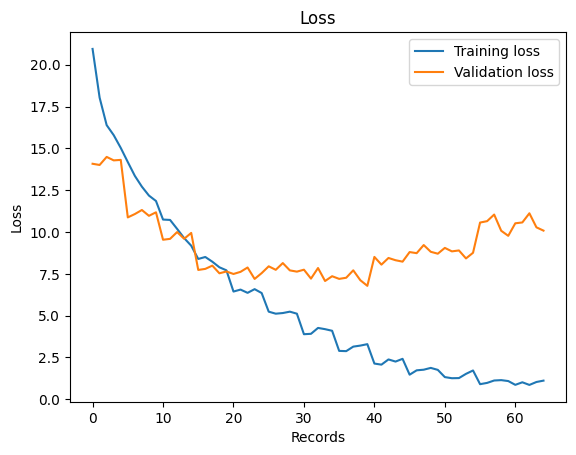

In [46]:
plt.plot(training_loss, label="Training loss")
plt.plot(validation_loss, label="Validation loss")
plt.legend(loc="upper right")
plt.title("Loss")
plt.xlabel("Records")
plt.ylabel("Loss")
plt.show()

(65, 10)


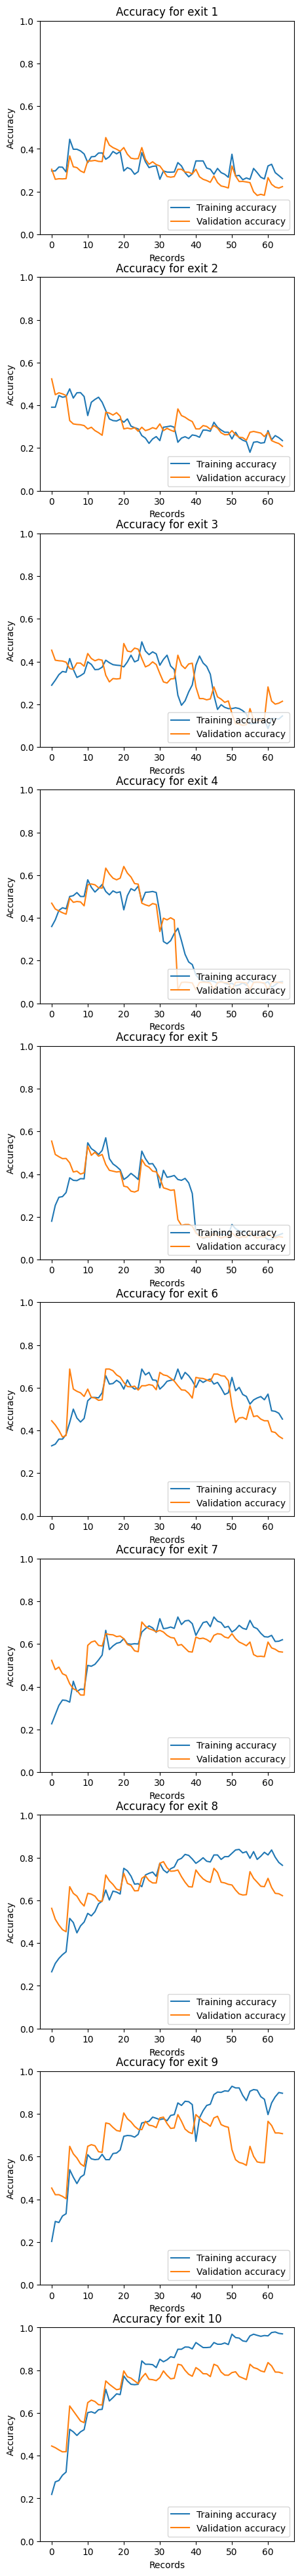

In [47]:
training_accuracy = np.array(training_accuracy)
validation_accuracy = np.array(validation_accuracy)
print(training_accuracy.shape)
fig, axs = plt.subplots(10, 1, figsize=(5, 50))
axs = axs.flatten()
for i in range(10):
    axs[i].plot(training_accuracy[:, i], label="Training accuracy")
    axs[i].plot(validation_accuracy[:, i], label="Validation accuracy")
    axs[i].legend(loc="lower right")
    axs[i].set_title(f"Accuracy for exit {i + 1}")
    axs[i].set_xlabel("Records")
    axs[i].set_ylabel("Accuracy")
    axs[i].set_ylim([0, 1])

### Using a different decision criterion for early exit (probability of the output)

In [48]:
#to check memory usage and gpu status
!nvidia-smi

Mon Nov 20 17:43:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    29W /  70W |   3067MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [49]:
class BVGG13_v3(nn.Module):
    def __init__(self, num_classes, batch_norm=False, dropout=False):
        super(BVGG13_v3, self).__init__()
        self.batch_norm = batch_norm
        self.dropout = dropout
        self.set_exit_threshold(0.0)

        self.conv_layers = nn.ModuleList(
            [
                # first block
                nn.Conv2d(3, 64, kernel_size=3, padding=1),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                # second block
                nn.Conv2d(64, 128, kernel_size=3, padding=1),
                nn.Conv2d(128, 128, kernel_size=3, padding=1),
                # third block
                nn.Conv2d(128, 256, kernel_size=3, padding=1),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                # fourth block
                nn.Conv2d(256, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                # fifth block
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
            ]
        )

        self.pool_layers = nn.ModuleList(
            [
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
            ]
        )

        if self.batch_norm:
            self.norm_layers = nn.ModuleList(
                [
                    nn.BatchNorm2d(64),
                    nn.BatchNorm2d(64),
                    nn.BatchNorm2d(128),
                    nn.BatchNorm2d(128),
                    nn.BatchNorm2d(256),
                    nn.BatchNorm2d(256),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                ]
            )
        else:
            self.norm_layers = nn.ModuleList(
                [
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                ]
            )

        if self.dropout:
            self.classifier = nn.Sequential(
                # 1st block
                nn.Linear(512 * 1 * 1, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                # 2nd block
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                # output
                nn.Linear(4096, num_classes),
            )
        else:
            self.classifier = nn.Sequential(
                # 1st block
                nn.Linear(512 * 1 * 1, 4096),
                nn.ReLU(inplace=True),
                # 2nd block
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                # output
                nn.Linear(4096, num_classes),
            )

        self.early_exits = nn.ModuleList(
            [
                create_early_exit(32, 64, num_classes),
                create_early_exit(16, 64, num_classes),
                create_early_exit(16, 128, num_classes),
                create_early_exit(8, 128, num_classes),
                create_early_exit(8, 256, num_classes),
                create_early_exit(4, 256, num_classes),
                create_early_exit(4, 512, num_classes),
                create_early_exit(2, 512, num_classes),
                create_early_exit(2, 512, num_classes),
            ]
        )

    def forward(self, x, inference=False):
        g_functions = []
        out = []
        soft_out = []
        e = 0
        for conv, norm, pool in zip(
            self.conv_layers, self.norm_layers, self.pool_layers
        ):
            x = conv(x)
            x = norm(x)
            F.relu(x, inplace=True)
            x = pool(x)
            if e < len(self.early_exits):
                x_ee = self.early_exits[e](x)
                out.append(x_ee)
                H = find_max_prob(x_ee)
                g_functions.append(H)
                e += 1
                if inference and torch.greater(H, self.exit_threshold):
                    return x_ee, H, e

        # flatten
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        out.append(x)
        last_H = find_max_prob(x)
        if inference:
            return x, last_H, len(soft_out)

        soft_out.append(x)

        k = len(g_functions) - 1
        for i, o in enumerate(out[-2::-1]):
            h = g_functions[k].unsqueeze(1)
            k -= 1
            # print(h.shape)
            # print(o.shape)
            f_tilde = h * o + (1 - h) * soft_out[-1]
            # print("Early exit", i)
            # print(f_tilde.detach().cpu())
            soft_out.append(f_tilde)

        soft_out.reverse()

        return out, soft_out

    def set_exit_threshold(self, exit_threshold):
        self.exit_threshold = torch.tensor(exit_threshold)

In [50]:
torch.manual_seed(42)
bvgg_v3 = BVGG13_v3(num_classes=10)
# print(vgg)
# print(check_train)
# print(check_val)

optimizer = optim.Adam(
    bvgg_v3.parameters(),
    lr=0.0005,
)

loss_fn = JointCrossEntropy()

n_epochs = 30

bvgg_v3.to(device)

start = time.time()
(
    training_loss,
    training_accuracy,
    validation_loss,
    validation_accuracy,
) = train_model_ee_v2(
    bvgg_v3,
    n_epochs,
    trainloader,
    valloader,
    optimizer,
    loss_fn,
    early_stopping=True,
    verbose=True,
)
end = time.time()
print(f"Training took {end - start:.2f} seconds")

Epoch 1	Training loss: 20.4515	Accuracy: [39.06 42.97 40.62 35.94 26.56 18.75 28.91 26.56 15.62 25.  ]
Epoch 1	Training loss: 17.5238	Accuracy: [44.53 41.8  41.02 38.28 31.64 30.47 32.03 28.52 19.53 26.95]
Epoch 1	Training loss: 15.8005	Accuracy: [48.44 46.88 44.53 39.84 35.16 33.59 34.9  31.77 24.48 30.47]
Epoch 1	Training loss: 15.1526	Accuracy: [50.2  48.05 44.73 40.43 37.11 35.74 36.13 33.98 28.52 30.86]
Epoch 1	Training loss: 14.3370	Accuracy: [52.19 50.16 46.41 41.09 40.62 37.97 38.44 35.94 31.25 33.59]
Epoch 1	Validation loss: 13.1678	Accuracy: [67.19 58.59 64.06 56.25 57.81 50.   56.25 53.12 50.78 50.78]
Epoch 1	Validation loss: 13.1566	Accuracy: [64.45 55.08 55.86 52.73 51.56 49.22 52.73 52.34 49.22 49.61]
Epoch 1	Validation loss: 13.4686	Accuracy: [63.02 54.43 57.03 52.34 52.86 48.44 51.56 50.   46.09 47.4 ]
Epoch 1	Validation loss: 13.1870	Accuracy: [63.09 53.91 55.27 51.95 52.15 47.46 51.56 49.02 46.29 46.88]
Epoch 1	Validation loss: 13.2944	Accuracy: [63.28 53.75 55.   52.

### Test data

In [51]:
# test accuracy
bvgg_v3.eval()

with torch.no_grad():
    for i in range(10):
        correct = 0
        total = 0
        start = time.time()
        for data, target in testloader:
            # move tensors to GPU if CUDA is available
            data = data.to(device)
            target = target.to(device)
            # forward pass
            output, soft_output = bvgg_v3(data, inference=False)
            # Test accuracy on the final exit
            _, pred = torch.max(output[i], dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)
        end = time.time()
        print(f"Exit {i+1} test accuracy: {correct / total * 100:.2f}%")
        print(f"Test took {end - start:.2f} seconds")

avg_acc = correct / total
print(f"the average accuracy is {100*avg_acc}")

Exit 1 test accuracy: 66.92%
Test took 3.31 seconds
Exit 2 test accuracy: 25.05%
Test took 4.58 seconds
Exit 3 test accuracy: 74.45%
Test took 3.66 seconds
Exit 4 test accuracy: 12.54%
Test took 3.81 seconds
Exit 5 test accuracy: 78.01%
Test took 3.23 seconds
Exit 6 test accuracy: 77.61%
Test took 4.69 seconds
Exit 7 test accuracy: 79.40%
Test took 3.56 seconds
Exit 8 test accuracy: 79.75%
Test took 3.29 seconds
Exit 9 test accuracy: 79.88%
Test took 3.26 seconds
Exit 10 test accuracy: 79.54%
Test took 4.56 seconds
the average accuracy is 79.54


### Inference time

In [104]:
bvgg_v3.eval()
test_iter = iter(testloader)
np.random.seed(666)
for i in range(np.random.randint(len(testloader))):
    img_batch, target_batch = next(test_iter)
img_idx = np.random.randint(batch_size)
img = img_batch[img_idx]
target = target_batch[img_idx]
img = img.unsqueeze(0).to(device)

bvgg_v3.set_exit_threshold(0.5)
with torch.no_grad():
    start = time.time()
    output, H, e = bvgg_v3(img, inference=True)
    end = time.time()
    print(f"Inference time {end - start:.8f} seconds")
    print(f"Exit: {e+1}")
    print(f"Probability: {H.detach().cpu()}")
    print(f"Output: {output.detach().cpu()}")
    _, pred = torch.max(output, dim=1)
    print(f"Prediction: {classes[pred]}")
    print(f"Target: {classes[target]}")

Inference time 0.00464106 seconds
Exit: 2
Probability: tensor([0.9795])
Output: tensor([[ 1.5635, -8.4827, -0.7630, -3.8541, -0.7110,  1.6951, -3.3547, -1.4403,
          6.3158, -2.5132]])
Prediction: ship
Target: ship


In [53]:
#to check memory usage and gpu status
!nvidia-smi

Mon Nov 20 17:49:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    39W /  70W |   3293MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

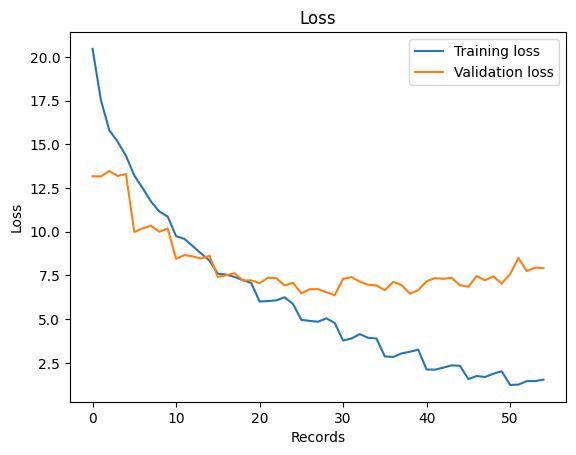

In [54]:
plt.plot(training_loss, label="Training loss")
plt.plot(validation_loss, label="Validation loss")
plt.legend(loc="upper right")
plt.title("Loss")
plt.xlabel("Records")
plt.ylabel("Loss")
plt.show()

(55, 10)


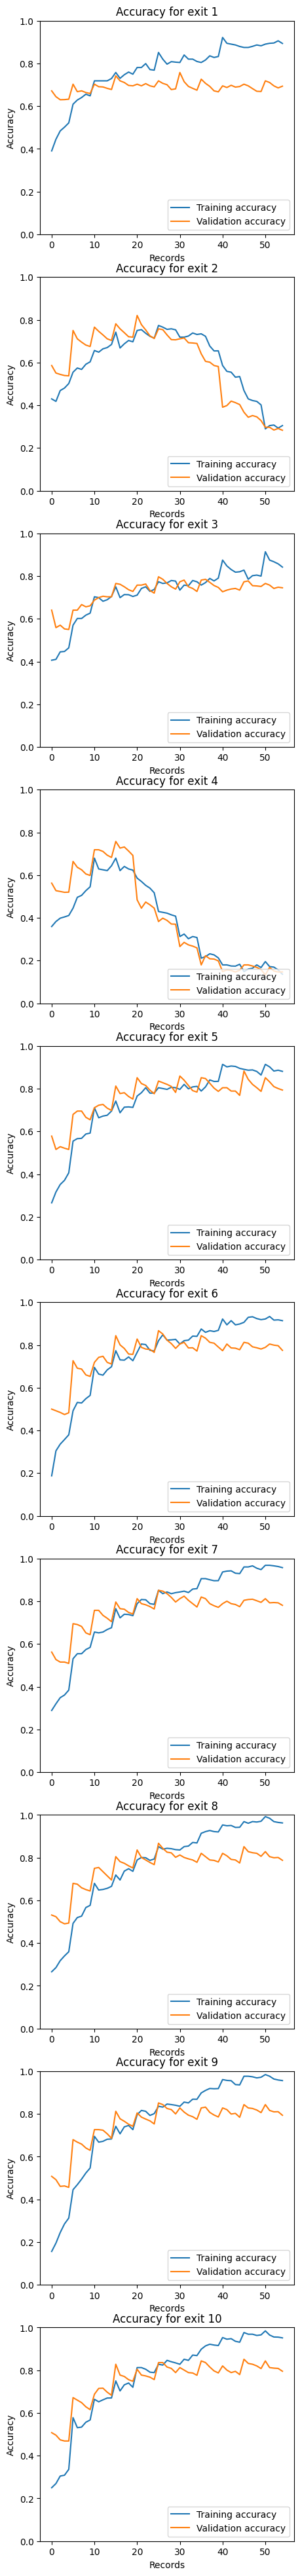

In [55]:
training_accuracy = np.array(training_accuracy)
validation_accuracy = np.array(validation_accuracy)
print(training_accuracy.shape)
fig, axs = plt.subplots(10, 1, figsize=(5, 50))
axs = axs.flatten()
for i in range(10):
    axs[i].plot(training_accuracy[:, i], label="Training accuracy")
    axs[i].plot(validation_accuracy[:, i], label="Validation accuracy")
    axs[i].legend(loc="lower right")
    axs[i].set_title(f"Accuracy for exit {i + 1}")
    axs[i].set_xlabel("Records")
    axs[i].set_ylabel("Accuracy")
    axs[i].set_ylim([0, 1])

In [56]:
print(f"GPU Memory Used: {humanize.naturalsize(gpu.memoryUsed)}")

GPU Memory Used: 0 Bytes
